In [2]:
from IPython.display import Image

In [21]:
import math
import numpy
import torch
import torch.nn as nn
import torch.nn.functional as F

- tensor parallel
    - 更细粒度的模型并行，细到 weight matrix （tensor）粒度
    - https://arxiv.org/abs/1909.08053（Megatron）
    - https://www.deepspeed.ai/tutorials/automatic-tensor-parallelism/
    - https://zhuanlan.zhihu.com/p/450689346
- 数学上：矩阵分块 (block matrix)


## 分块矩阵

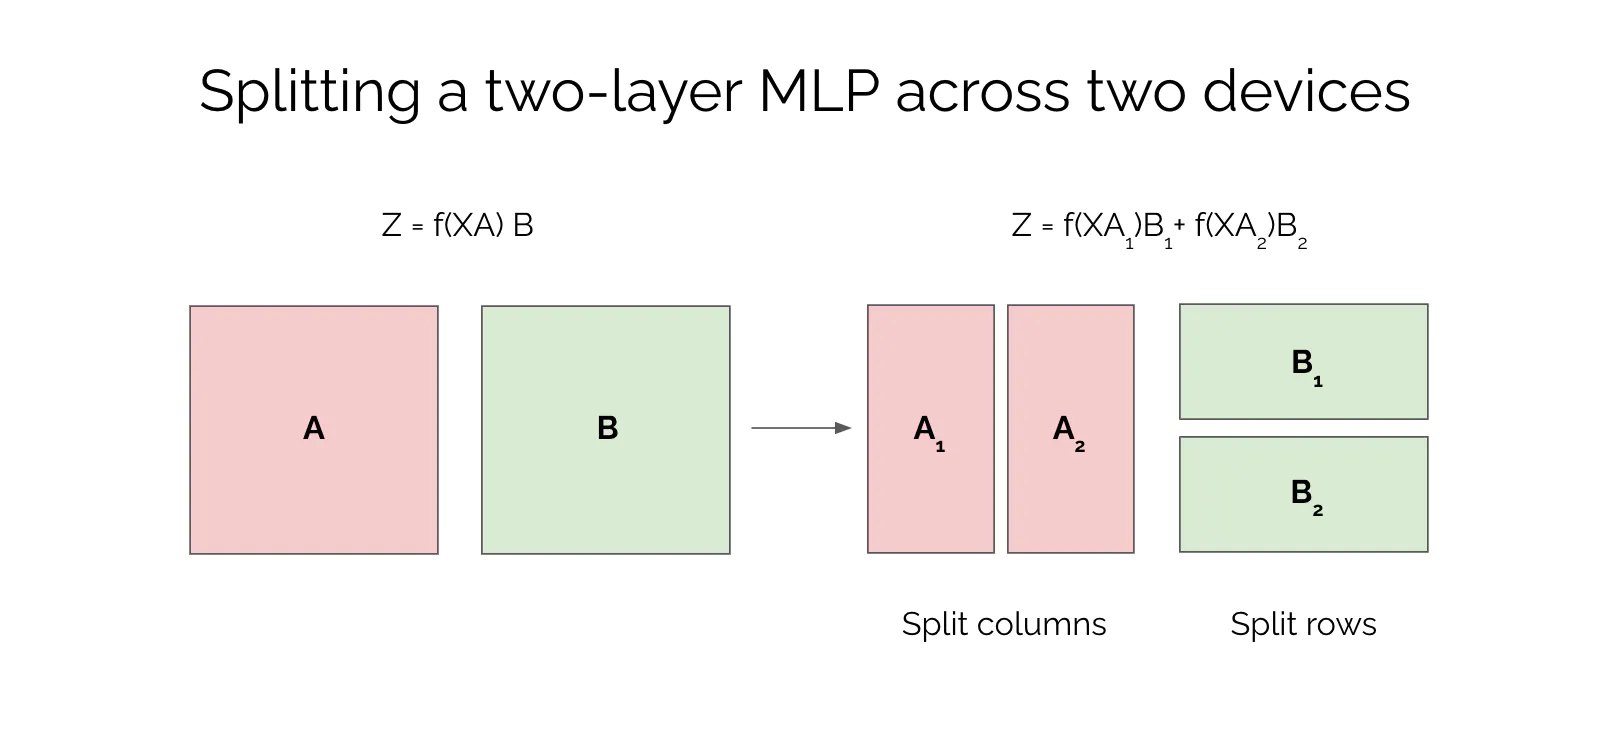

In [7]:
Image('../imgs/split_two_layer_mlp.png', width=600)

- $A=\begin{bmatrix} A_1, A_2\end{bmatrix}$：按列分块（column-wise splits）
    - $A\in \mathbb R^{200\times 300}$
    - $A_i\in \mathbb R^{200\times 150}$
- $B=\begin{bmatrix} B_1\\B_2\end{bmatrix}$：按行分块（row-wise splits）
    - $B\in \mathbb R^{300\times 400}$
    - $B_j\in \mathbb R^{150\times 400}$
- $f(\cdot)$ 的操作是 element-wise 的，其实就是激活函数（比如 `tanh`）
    - $A$ 的列数 = $B$ 的行数
    - $A_i$ 的列数 = $B_j$ 的行数

$$
\begin{split}
f(X\cdot A)\cdot B&=f\left(X\begin{bmatrix}A_1,A_2\end{bmatrix}\right)\cdot\begin{bmatrix}B_1\\B_2\end{bmatrix}\\
&=\begin{bmatrix}f(XA_1),f(XA_2)\end{bmatrix}\cdot\begin{bmatrix}B_1\\B_2\end{bmatrix}\\
&=f(XA_1)\cdot B_1+f(XA_2)\cdot B_2
\end{split}
$$

In [1]:
import numpy as np

In [8]:
X = np.random.randn(100, 200)
A = np.random.randn(200, 300)
# XA = 100*300
B = np.random.randn(300, 400)

In [1]:
def split_columnwise(A, num_splits):
    return np.split(A, num_splits, axis=1)
 
def split_rowwise(A, num_splits):
    return np.split(A, num_splits, axis=0)

In [10]:
def normal_forward_pass(X, A, B, f):
    Y = f(np.dot(X, A))
    Z = np.dot(Y, B)
    return Z

In [18]:
def tensor_parallel_forward_pass(X, A, B, f):
    A1, A2 = split_columnwise(A, 2)
    B1, B2 = split_rowwise(B, 2)
    Y1 = f(np.dot(X, A1))
    Y2 = f(np.dot(X, A2))
    Z1 = np.dot(Y1, B1)
    Z2 = np.dot(Y2, B2)
#     Z = np.sum([Z1, Z2], axis=0)
    Z = Z1+Z2
    return Z

In [19]:
Z_normal = normal_forward_pass(X, A, B, np.tanh)
Z_tensor = tensor_parallel_forward_pass(X, A, B, np.tanh)

In [21]:
Z_tensor.shape

(100, 400)

In [20]:
np.allclose(Z_normal, Z_tensor)

True

## FFN

- h -> 4h
- 4h -> h

### ffn of bert

In [85]:
from transformers import AutoModel

In [86]:
import os
os.environ["http_proxy"] = "http://127.0.0.1:7890"
os.environ["https_proxy"] = "http://127.0.0.1:7890"

In [87]:
bert = AutoModel.from_pretrained('bert-base-uncased')

In [8]:
# h => 4h
bert.encoder.layer[0].intermediate

BertIntermediate(
  (dense): Linear(in_features=768, out_features=3072, bias=True)
  (intermediate_act_fn): GELUActivation()
)

In [9]:
# 4h -> h
bert.encoder.layer[0].output

BertOutput(
  (dense): Linear(in_features=3072, out_features=768, bias=True)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

### ffn cases

$$
\begin{split}
(X\cdot W_1)\cdot W_2&=\left(X\cdot \begin{bmatrix}W_{11}, W_{12} \end{bmatrix}\right)\cdot \begin{bmatrix}W_{21}\\W_{22}\end{bmatrix}\\
&=\begin{bmatrix}X\cdot W_{11}, X\cdot W_{12}\end{bmatrix}\cdot \begin{bmatrix}W_{21}\\W_{22}\end{bmatrix}\\
&=(X\cdot W_{11})W_{21}+(X\cdot W_{12})W_{22}
\end{split}
$$

- X: (1, 5, 10)
- W1: (10, 40), h->4h
    - W11: (10, 20), 0:20
    - W12: (10, 20), 20:40
- W2: (40, 10), 4h->h
    - W21: (20, 10), 0:20
    - W22: (20, 10), 20:40

In [11]:
input = torch.randn(size=(1, 5, 10), dtype=torch.float32)

In [13]:
embedding_dim = input.size(2)
embedding_dim

10

In [20]:
dense_h_to_4h = nn.Linear(embedding_dim, embedding_dim*4, bias=False)
# (1, 5, 10) -> (1, 5, 40)
output1 = dense_h_to_4h(input)
output1.shape

torch.Size([1, 5, 40])

In [21]:
dense_4h_to_h = nn.Linear(embedding_dim*4, embedding_dim, bias=False)
# (1, 5, 40) -> (1, 5, 10)
output2 = dense_4h_to_h(output1)
output2.shape

torch.Size([1, 5, 10])

In [28]:
n_devices = 2
half_4h = embedding_dim*4//n_devices

In [32]:
# (1, 5, 10) -> (1, 5, 20)
dense_h_to_4h_parallel = nn.Linear(embedding_dim, half_4h, bias=False)
dense_h_to_4h_parallel.weight.data = dense_h_to_4h.weight[:half_4h, :]
first_h_to_4h = dense_h_to_4h_parallel(input)
first_h_to_4h.shape

torch.Size([1, 5, 20])

In [33]:
# (1, 5, 10) -> (1, 5, 20)
dense_h_to_4h_parallel = nn.Linear(embedding_dim, half_4h, bias=False)
dense_h_to_4h_parallel.weight.data = dense_h_to_4h.weight[half_4h:, :]
second_h_to_4h = dense_h_to_4h_parallel(input)
second_h_to_4h.shape

torch.Size([1, 5, 20])

In [35]:
dense_4h_to_h_parallel = nn.Linear(half_4h, embedding_dim, bias=False)
dense_4h_to_h_parallel.weight.data = dense_4h_to_h.weight[:, :half_4h]
first_4h_to_h = dense_4h_to_h_parallel(first_h_to_4h)
first_4h_to_h.shape

torch.Size([1, 5, 10])

In [36]:
dense_4h_to_h_parallel = nn.Linear(half_4h, embedding_dim, bias=False)
dense_4h_to_h_parallel.weight.data = dense_4h_to_h.weight[:, half_4h:]
second_4h_to_h = dense_4h_to_h_parallel(second_h_to_4h)
second_4h_to_h.shape

torch.Size([1, 5, 10])

In [37]:
first_4h_to_h + second_4h_to_h

tensor([[[ 0.0529, -0.0688, -0.0587,  0.2476,  0.3799,  0.1713, -0.1616,
           0.0428, -0.1615,  0.1838],
         [ 0.1270, -0.2606,  0.0909, -0.2700, -0.3233, -0.1638, -0.2940,
           0.2188,  0.1833,  0.0383],
         [ 0.1431, -0.1707,  0.0511, -0.0807, -0.0090, -0.0254, -0.1386,
           0.0683, -0.1014,  0.0271],
         [-0.6097, -0.4574,  0.3217,  0.4221, -0.0391,  0.2831, -0.0703,
          -0.7628, -0.1539,  0.0447],
         [ 0.1610,  0.4283, -0.1030,  0.2027,  0.0192,  0.0633, -0.1505,
          -0.0723, -0.0075,  0.0093]]], grad_fn=<AddBackward0>)

In [38]:
output2

tensor([[[ 0.0529, -0.0688, -0.0587,  0.2476,  0.3799,  0.1713, -0.1616,
           0.0428, -0.1615,  0.1838],
         [ 0.1270, -0.2606,  0.0909, -0.2700, -0.3233, -0.1638, -0.2940,
           0.2188,  0.1833,  0.0383],
         [ 0.1431, -0.1707,  0.0511, -0.0807, -0.0090, -0.0254, -0.1386,
           0.0683, -0.1014,  0.0271],
         [-0.6097, -0.4574,  0.3217,  0.4221, -0.0391,  0.2831, -0.0703,
          -0.7628, -0.1539,  0.0447],
         [ 0.1610,  0.4283, -0.1030,  0.2027,  0.0192,  0.0633, -0.1505,
          -0.0723, -0.0075,  0.0093]]], grad_fn=<UnsafeViewBackward0>)

## Attention

```
Attention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
```

- 本节用到的矩阵 `Wq`, `Wk`, `Wv`, `Wo`
```
Attention(
          (q_proj): Linear(in_features=32, out_features=32, bias=False)
          (k_proj): Linear(in_features=32, out_features=32, bias=False)
          (v_proj): Linear(in_features=32, out_features=32, bias=False)
          (o_proj): Linear(in_features=32, out_features=32, bias=False)
        )
```

In [92]:
bert.encoder.layer[0].attention

BertAttention(
  (self): BertSelfAttention(
    (query): Linear(in_features=768, out_features=768, bias=True)
    (key): Linear(in_features=768, out_features=768, bias=True)
    (value): Linear(in_features=768, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (output): BertSelfOutput(
    (dense): Linear(in_features=768, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [95]:
4096/32

128.0

$$
\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

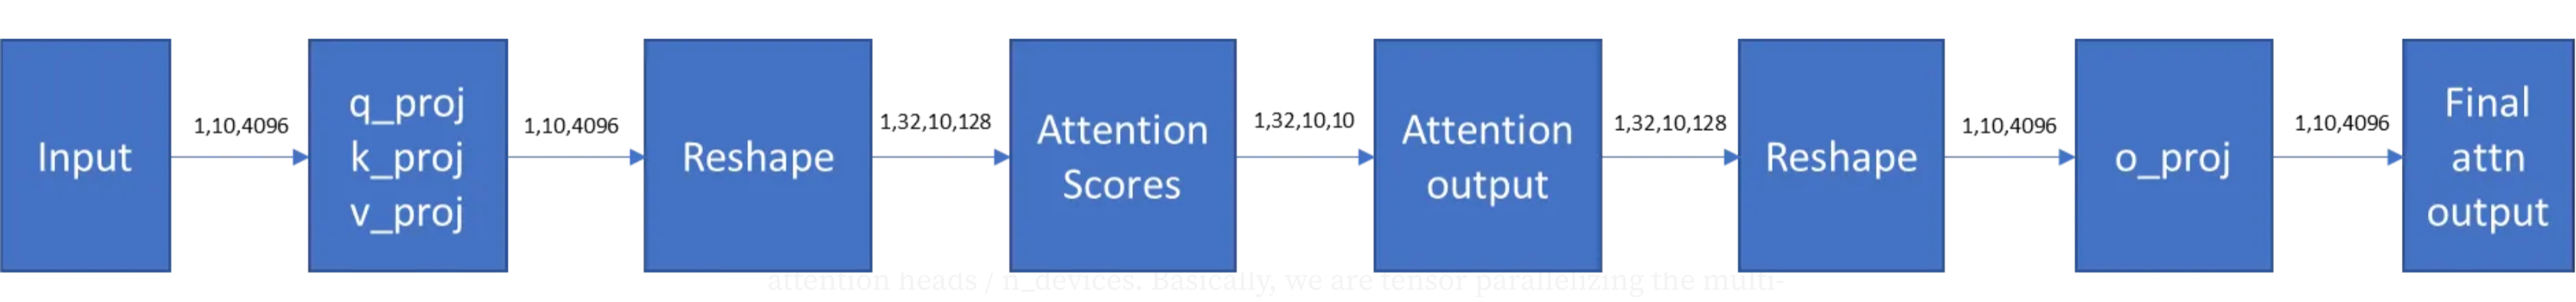

In [93]:
Image('../imgs/attn_with_shape.png')

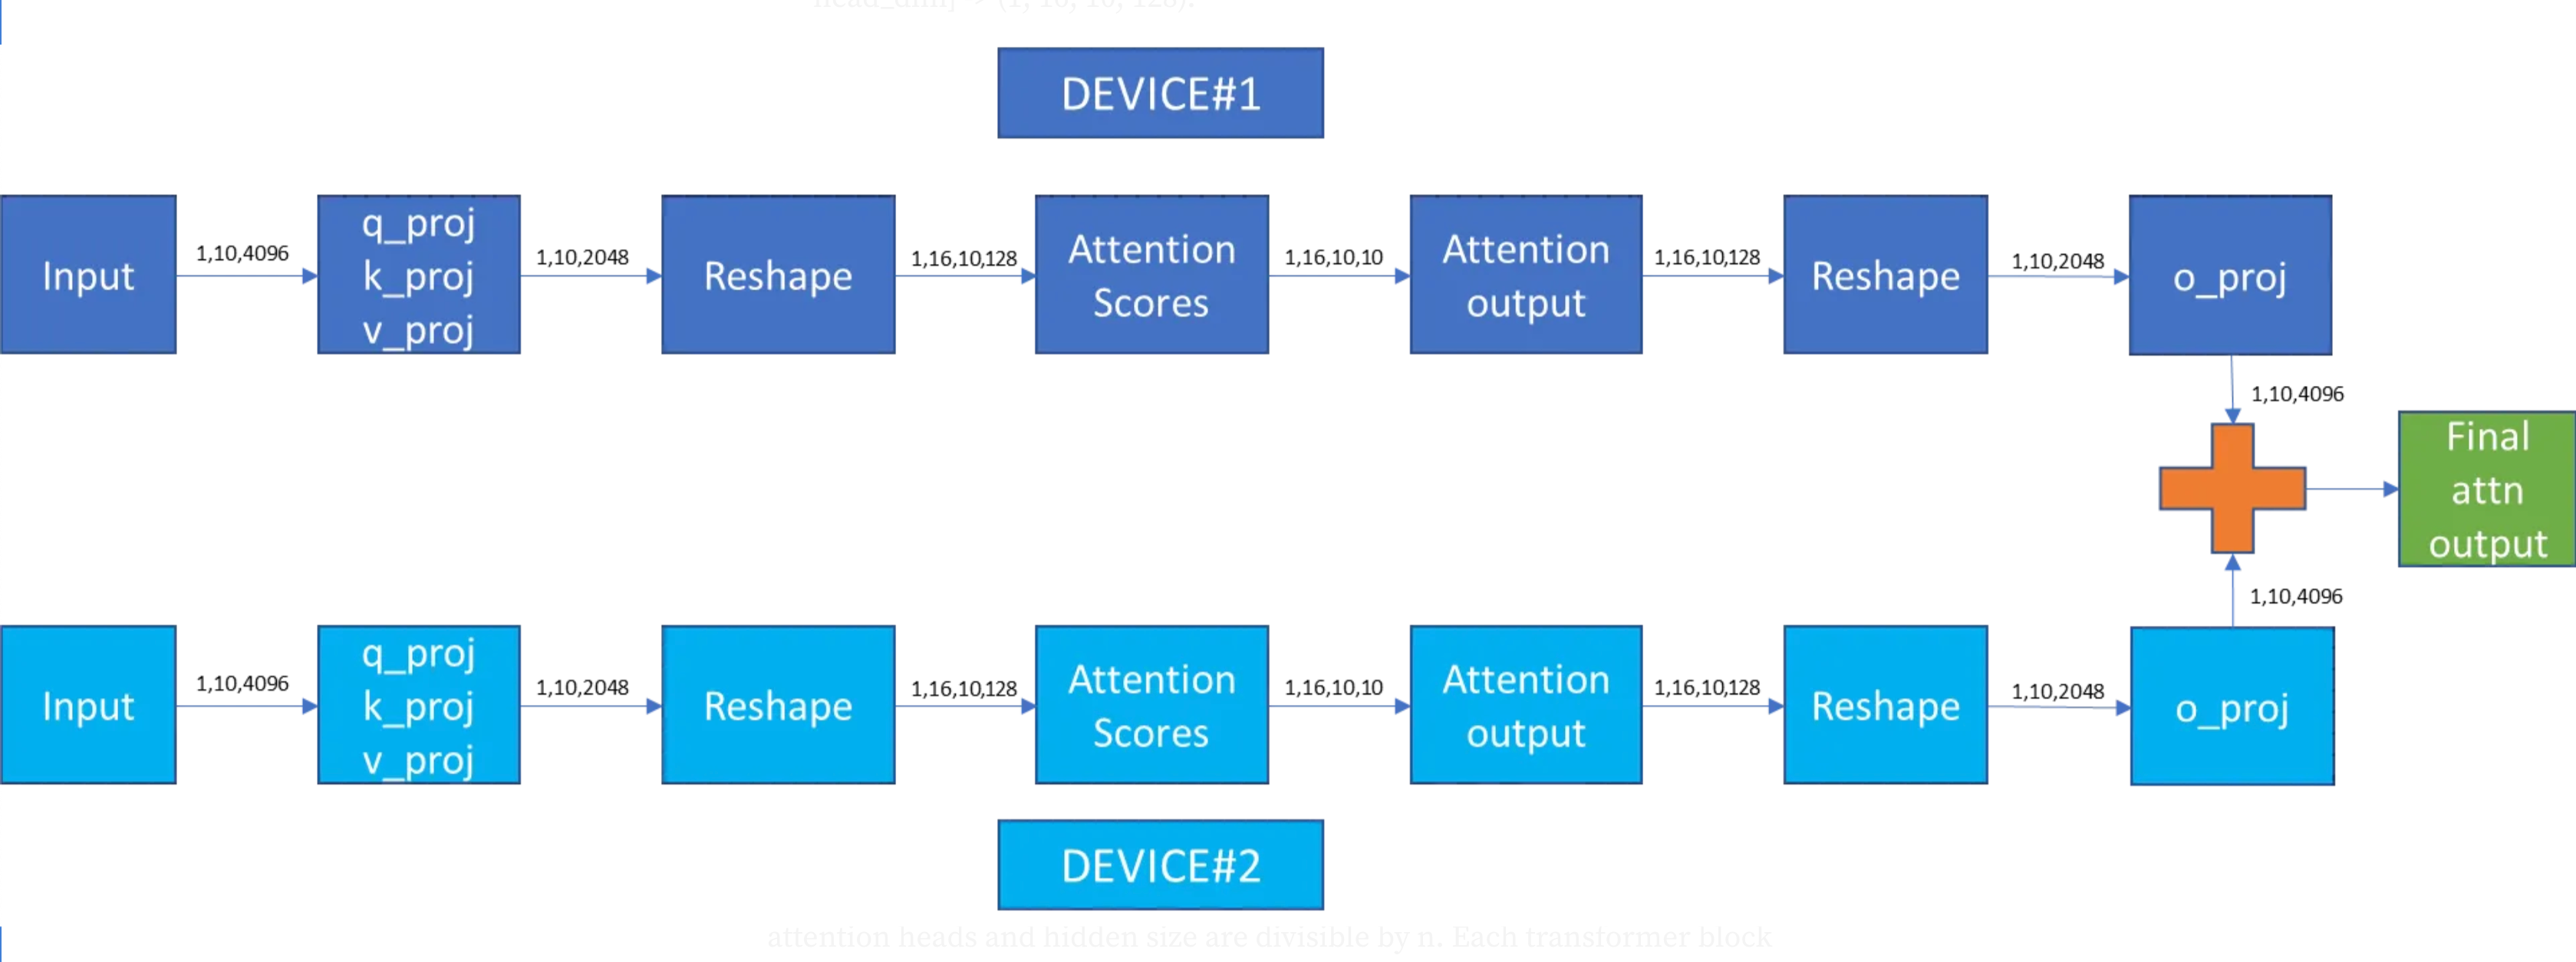

In [94]:
Image('../imgs/attn_with_shape_tp.png')

In [4]:
input = torch.randn(size=(1, 5, 32), dtype=torch.float32)

In [5]:
bsz, seq_len, hidden_size = input.size()
hidden_size     

32

In [78]:
num_heads = 4
# 4*8 == 32
head_dim = hidden_size // num_heads
head_dim

8

In [11]:
# 4个大方阵
Wq = nn.Linear(hidden_size, num_heads*head_dim, bias=False)
Wk = nn.Linear(hidden_size, num_heads*head_dim, bias=False)
Wv = nn.Linear(hidden_size, num_heads*head_dim, bias=False)
Wo = nn.Linear(num_heads*head_dim, hidden_size, bias=False)

In [79]:
# bsz, seq_len, num_heads*head_dim
q = Wq(input)
k = Wk(input)
v = Wv(input)

# bsz, seq_len, num_heads, head_dim
# bsz, num_heads, seq_len, head_dim
q = q.view(bsz, seq_len, num_heads, head_dim).transpose(1, 2)
# bsz, num_heads, seq_len, head_dim
k = k.view(bsz, seq_len, num_heads, head_dim).transpose(1, 2)
v = v.view(bsz, seq_len, num_heads, head_dim).transpose(1, 2)
v.shape

torch.Size([1, 4, 5, 8])

In [80]:
# bsz, num_heads, seq_len, seq_len
attn_weights = torch.matmul(q, k.transpose(2, 3))/math.sqrt(head_dim)
attn_weights.shape

torch.Size([1, 4, 5, 5])

In [81]:
attn_weights = F.softmax(attn_weights, dim=-1)
attn_output = torch.matmul(attn_weights, v)
attn_output.shape

torch.Size([1, 4, 5, 8])

In [82]:
attn_output = attn_output.transpose(1, 2).contiguous()
attn_output = attn_output.reshape(bsz, seq_len, num_heads*head_dim)
attn_output.shape

torch.Size([1, 5, 32])

In [83]:
attn_output_non_tp = Wo(attn_output)
attn_output_non_tp.shape

torch.Size([1, 5, 32])

In [84]:
attn_output_non_tp

tensor([[[ 0.0731,  0.0677,  0.0727, -0.3610, -0.0888, -0.3159, -0.0285,
          -0.1515, -0.4439, -0.0367,  0.0444,  0.0269,  0.1433,  0.3953,
           0.0253, -0.1142, -0.0564, -0.1178,  0.1610, -0.1232,  0.2266,
           0.0408, -0.1204, -0.2883, -0.0732,  0.0348, -0.0089, -0.3937,
           0.1204, -0.2409,  0.1285,  0.0552],
         [ 0.1096,  0.1074,  0.0774, -0.3172, -0.0989, -0.3062,  0.0372,
          -0.0621, -0.3667, -0.1536,  0.0455,  0.0594,  0.2223,  0.3104,
           0.1757, -0.1498, -0.0395,  0.0674,  0.1414, -0.2221,  0.1329,
           0.0447, -0.0861, -0.1599, -0.0812,  0.0468,  0.0103, -0.3880,
           0.0983, -0.3005,  0.0234,  0.1525],
         [ 0.0118,  0.1357,  0.0765, -0.3419, -0.1109, -0.1634,  0.0464,
           0.0475, -0.3440, -0.2165,  0.0274,  0.1135,  0.1785,  0.3927,
           0.2349, -0.1480, -0.0856,  0.1393,  0.1821, -0.2603,  0.0897,
           0.0013, -0.2009, -0.2599, -0.1740, -0.0713,  0.0056, -0.3991,
           0.1248, -0.3200,  0

### tp of Attention

In [36]:
n_devices = 2
num_heads = num_heads // n_devices

In [38]:
Wq.weight.shape

torch.Size([32, 32])

In [45]:
Wq_blocks = Wq.weight.split(num_heads * head_dim, dim=0)
print(q_blocks[0].shape)
print(q_blocks[1].shape)

torch.Size([16, 32])
torch.Size([16, 32])


In [44]:
Wk_blocks = Wk.weight.split(num_heads * head_dim, dim=0)
Wv_blocks = Wv.weight.split(num_heads * head_dim, dim=0)

In [46]:
Wo_blocks = Wo.weight.split(num_heads * head_dim, dim=1)
print(Wo_blocks[0].shape)
print(Wo_blocks[1].shape)

torch.Size([32, 16])
torch.Size([32, 16])


In [49]:
# first device
q1 = F.linear(input, Wq_blocks[0])
k1 = F.linear(input, Wk_blocks[0])
v1 = F.linear(input, Wv_blocks[0])
q1.shape

torch.Size([1, 5, 16])

In [50]:
q1 = q1.view(bsz, seq_len, num_heads, head_dim).transpose(1, 2)
k1 = k1.view(bsz, seq_len, num_heads, head_dim).transpose(1, 2)
v1 = v1.view(bsz, seq_len, num_heads, head_dim).transpose(1, 2)

In [67]:
attn_weights = torch.matmul(q1, k1.transpose(2, 3)) / math.sqrt(head_dim)
attn_weights = F.softmax(attn_weights, dim=-1)
attn_output1 = torch.matmul(attn_weights, v1)
attn_output1 = attn_output1.transpose(1, 2).contiguous()
attn_output1.shape

torch.Size([1, 5, 2, 8])

In [68]:
attn_output1 = attn_output1.reshape(bsz, seq_len, num_heads*head_dim)

In [69]:
attn_output1.shape

torch.Size([1, 5, 16])

In [70]:
Wo_blocks[0].shape

torch.Size([32, 16])

In [71]:
attn_output1 = F.linear(attn_output1, Wo_blocks[0])
attn_output1.shape

torch.Size([1, 5, 32])

In [75]:
# second device
q2 = F.linear(input, Wq_blocks[1])
k2 = F.linear(input, Wk_blocks[1])
v2 = F.linear(input, Wv_blocks[1])
q2 = q2.view(bsz, seq_len, num_heads, head_dim).transpose(1, 2)
k2 = k2.view(bsz, seq_len, num_heads, head_dim).transpose(1, 2)
v2 = v2.view(bsz, seq_len, num_heads, head_dim).transpose(1, 2)
attn_weights = torch.matmul(q2, k2.transpose(2, 3)) / math.sqrt(head_dim)
attn_weights = F.softmax(attn_weights, dim=-1)
attn_output2 = torch.matmul(attn_weights, v2)
attn_output2 = attn_output2.transpose(1, 2).contiguous()
attn_output2 = attn_output2.reshape(bsz, seq_len, num_heads*head_dim)
attn_output2 = F.linear(attn_output2, Wo_blocks[1])
attn_output2.shape

torch.Size([1, 5, 32])

In [76]:
attn_output1 + attn_output2

tensor([[[ 0.0731,  0.0677,  0.0727, -0.3610, -0.0888, -0.3159, -0.0285,
          -0.1515, -0.4439, -0.0367,  0.0444,  0.0269,  0.1433,  0.3953,
           0.0253, -0.1142, -0.0564, -0.1178,  0.1610, -0.1232,  0.2266,
           0.0408, -0.1204, -0.2883, -0.0732,  0.0348, -0.0089, -0.3937,
           0.1204, -0.2409,  0.1285,  0.0552],
         [ 0.1096,  0.1074,  0.0774, -0.3172, -0.0989, -0.3062,  0.0372,
          -0.0621, -0.3667, -0.1536,  0.0455,  0.0594,  0.2223,  0.3104,
           0.1757, -0.1498, -0.0395,  0.0674,  0.1414, -0.2221,  0.1329,
           0.0447, -0.0861, -0.1599, -0.0812,  0.0468,  0.0103, -0.3880,
           0.0983, -0.3005,  0.0234,  0.1525],
         [ 0.0118,  0.1357,  0.0765, -0.3419, -0.1109, -0.1634,  0.0464,
           0.0475, -0.3440, -0.2165,  0.0274,  0.1135,  0.1785,  0.3927,
           0.2349, -0.1480, -0.0856,  0.1393,  0.1821, -0.2603,  0.0897,
           0.0013, -0.2009, -0.2599, -0.1740, -0.0713,  0.0056, -0.3991,
           0.1248, -0.3200,  0